## Imports

In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf

from openmm.unit import Quantity, Unit
from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB

from openmm.unit import molar, kilogram, picoseconds
from dataclasses import dataclass

import quantities
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from pymbar import timeseries
from MDAnalysis.analysis import density
from tqdm import tqdm
import os
import json
from pathlib import Path


/tmp/ipykernel_641815/282157214.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*             

## Set working directory

In [2]:
working_dir=os.getcwd()
os.chdir(f"{working_dir}/OpenFF2.1") #Change to whichever directory the input files are located

## Constants & variables defined from simulation setup

In [3]:
R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA # gas constant

In [5]:
global k
knm = 4184 * kilojoule_per_mole / nanometer**2
k=knm.in_units_of(kilojoule_per_mole/angstrom**2)

In [6]:
@dataclass
class Wall:
    '''For representing info about the location and orientation of a wall'''
    wall_pos : Quantity
    wall_normal : Quantity

@dataclass
class IonMolalInfo:
    '''For representing info about the systems' molecular composition'''
    molality : Quantity
    n_parts : int
    osm_coeff_exp : float
    molarity : Quantity = None

from typing import TypeAlias, TypeVar
Shape : TypeAlias = tuple
N = TypeVar('N')
M = TypeVar('M')

In [7]:
# define wall positions and ion conc parameters. This can be changed according to simulation set up.
walls = [
    Wall(
        wall_pos   =np.array([0.0, 0.0, 48.0]) * angstrom,
        wall_normal=np.array([0.0, 0.0, -1.0]) * angstrom,
    ),
    Wall(
        wall_pos   =np.array([0.0, 0.0, 96.0]) * angstrom,
        wall_normal=np.array([0.0, 0.0, 1.0]) * angstrom,
    ),
]

molal_infos = {
    1 : IonMolalInfo(
        molality=1.0*(mole / kilogram),
        n_parts=65,
        osm_coeff_exp=0.940,
        # molarity=0.98*molar
    ),
    2 : IonMolalInfo(
        molality=2.0*(mole / kilogram),
        n_parts=128,
        osm_coeff_exp=0.984,
        # molarity=1.92*molar
    ),
    3 : IonMolalInfo(
        molality=3.0*(mole / kilogram),
        n_parts=188,
        osm_coeff_exp=1.045,
        # molarity=2.82*molar
    ),
}

## Loading data and creating atom group of ions

Note: OpenMM code outputs dcd trajectory files, which where converted to xtc using the package mdtraj's function mdconvert since mdanalysis does not read the dcd files correctly and brings out errors.

In [8]:
## 1 molal ##
u1m_o = mda.Universe('mdr4_1m.pdb', 'mdr4_1m.xtc')
u1m_o.transfer_to_memory()
ions1m_o= u1m_o.select_atoms('resname NA CL')

u1m_r1 = mda.Universe('mdr1_1m.pdb', 'mdr1_1m.xtc')
u1m_r1.transfer_to_memory()
ions1m_r1= u1m_r1.select_atoms('resname NA CL')

u1m_r2 = mda.Universe('mdr2_1m.pdb', 'mdr2_1m.xtc')
u1m_r2.transfer_to_memory()
ions1m_r2= u1m_r2.select_atoms('resname NA CL')

u1m_r3 = mda.Universe('mdr3_1m.pdb', 'mdr3_1m.xtc')
u1m_r3.transfer_to_memory()
ions1m_r3= u1m_r3.select_atoms('resname NA CL')

us_1m = [u1m_o,u1m_r1,u1m_r2,u1m_r3]
ions_1m = [ions1m_o,ions1m_r1,ions1m_r2,ions1m_r3]

# ## 2 molal ##
u2m_o = mda.Universe('mdr4_2m.pdb', 'mdr4_2m.xtc')
u2m_o.transfer_to_memory()
ions2m_o= u2m_o.select_atoms('resname NA CL')

u2m_r1 = mda.Universe('mdr1_2m.pdb', 'mdr1_2m.xtc')
u2m_r1.transfer_to_memory()
ions2m_r1= u2m_r1.select_atoms('resname NA CL')

u2m_r2 = mda.Universe('mdr2_2m.pdb', 'mdr2_2m.xtc')
u2m_r2.transfer_to_memory()
ions2m_r2= u2m_r2.select_atoms('resname NA CL')

u2m_r3 = mda.Universe('mdr3_2m.pdb', 'mdr3_2m.xtc')
u2m_r3.transfer_to_memory()
ions2m_r3= u2m_r3.select_atoms('resname NA CL')

us_2m = [u2m_o,u2m_r1,u2m_r2,u2m_r3]
ions_2m = [ions2m_o,ions2m_r1,ions2m_r2,ions2m_r3]

# ## 3 molal ##
u3m_o = mda.Universe('mdr4_3m.pdb', 'mdr4_3m.xtc')
u3m_o.transfer_to_memory()
ions3m_o= u3m_o.select_atoms('resname NA CL')

u3m_r1 = mda.Universe('mdr1_3m.pdb', 'mdr1_3m.xtc')
u3m_r1.transfer_to_memory()
ions3m_r1= u3m_r1.select_atoms('resname NA CL')

u3m_r2 = mda.Universe('mdr2_3m.pdb', 'mdr2_3m.xtc')
u3m_r2.transfer_to_memory()
ions3m_r2= u3m_r2.select_atoms('resname NA CL')

u3m_r3 = mda.Universe('mdr3_3m.pdb', 'mdr3_3m.xtc')
u3m_r3.transfer_to_memory()
ions3m_r3= u3m_r3.select_atoms('resname NA CL')

us_3m = [u3m_o,u3m_r1,u3m_r2,u3m_r3]
ions_3m = [ions3m_o,ions3m_r1,ions3m_r2,ions3m_r3]

## Utility functions

In [9]:
def osmotic_values(
        mean_force_wall : Quantity, 
        molarity : Quantity,
        cross_sectional_area : Quantity, 
        vant_hoff : int=2,
        T : Quantity=300*kelvin, 
        printvals : bool=False
    ) -> Quantity:
    '''Compute osmotic pressure and coefficient from mean force from wall'''
    osm_press=mean_force_wall/cross_sectional_area
    osm_bar = osm_press.in_units_of(bar / mole)
    osm_bar = osm_bar/AVOGADRO_CONSTANT_NA
    
    osm_press_ideal=vant_hoff*molarity*R*T
    osm_press_ideal=osm_press_ideal.in_units_of(bar)
    osm_coeff=osm_bar/osm_press_ideal
    
    if printvals:
        print(f"Osmotic Pressure Observed:", osm_bar)
        print(f"Osmotic Pressure Ideal:", osm_press_ideal)
        print(f"Osmotic Coefficient:", osm_coeff)

    return osm_bar, osm_coeff

In [10]:
def filter_coords_by_wall(
    coords_rel_wall : np.ndarray[Shape[N, M, 3], float], 
    wall_normal : np.ndarray[Shape[3], float],
    dist_unit : Unit=angstrom,
) -> np.ndarray[Shape[N, M, 3], float]:
    '''Zeros out all coordinates which are not in the normal direction relative to a wall'''
    in_right_direction = np.dot(coords_rel_wall, wall_normal) > 0.0
    return np.where(in_right_direction[..., np.newaxis], coords_rel_wall, 0.0) * dist_unit # need to broadcast direction bools, since dot product reduces dimension along xyz

In [11]:
def calculate_force_matrix_all_ions_rel_wall(
    coords : np.ndarray[Shape[N, M, 3], float], 
    wall_pos : np.ndarray[Shape[3], float],
    wall_normal : np.ndarray[Shape[3], float],
    K : Quantity,
    dist_unit : Unit=angstrom,
) -> np.ndarray[Shape[M], float]:
    '''Calculates net harmonic force experience by particle on one side of a wall
    coords should be a 3D array with axes of time, ion index, and spatial coordinate, respectively
    wall_pos is a vector describing the position of the wall in space
    wall_normal gives the normal direction relative to the wall (to determine whether particles behnd or ahead of the wall are kept)'''
    coords_rel_wall = coords - wall_pos
    coords_behind_wall = filter_coords_by_wall(coords_rel_wall, wall_normal=wall_normal, dist_unit=dist_unit)
    z_coords_rel_wall = coords_behind_wall[..., 2]

    # NOTE: cannot use np.abs, as this will discard unit info
    return K * abs(z_coords_rel_wall) # sum along time dimension to leave array with 1 force per particle


In [12]:
def get_universe_area_and_volume(u : mda.Universe) -> tuple[Quantity, Quantity]:
    '''Returns the XY-plane area and box volume of an MDAnalysis universe'''
    box_sizes = u.dimensions[:3] * angstrom
    box_x, box_y, box_z = box_sizes

    A_box = box_x * box_y
    V_box = A_box * box_z

    return A_box, V_box

## Analysis

In [13]:
def SPW_analysis(
        times : np.ndarray[1, Quantity],
        ion_coords : np.ndarray[Shape[N, M, 3], Quantity],
        molality_info : IonMolalInfo,
        A_box : Quantity,
        walls : list[Wall],
        repnum : int,
        nskip : int=100,
    ) -> None:
    '''Function that calculates osmotic pressure, osmotic coefficient, 
        and performs uncorrelated sample analysis for flat-bottom potential 
        results given as inputs'''

    SPACER = f'\n{"-"*50}\n'

    print(SPACER)
    print(f"CONCENTRATION: {molality_info.molality}")

    #Specifying replicate number
    if repnum == 0:
        print("Data for original run")
    else:
        print("Data for replicate #",repnum)

    ## calculation of mean force matrix
    force_matrices = [
        calculate_force_matrix_all_ions_rel_wall(
            ion_coords,
            wall_pos=wall.wall_pos,
            wall_normal=wall.wall_normal,
            K=k,
            dist_unit=angstrom
        )    
        for wall in walls
     ]

    if force_matrices:
        NULL_FORCE = 0.0 * force_matrices[0].unit # needed to get sum to start with the right units (can't just add to 0)

    force_matrix = sum(force_matrices, start=NULL_FORCE) / len(force_matrices) # NOTE: need to average over all walls, and numpy can't get the job done on its own
    forces_time_avg = force_matrix.mean(axis=0)
    forces_over_all_ions = force_matrix.sum(axis=1)

    ## calculation of autocorrelation function and plot of uncorrelated samples
    # statistical values of t0 (time after equil), g (statistical efficiency/correlation time of equil data), Neff (# of eff samples)
    t0, g, Neff_max = timeseries.detect_equilibration(forces_over_all_ions._value, nskip=nskip) # compute indices of uncorrelated timeseries
    forces_over_all_ions_equil = forces_over_all_ions[t0:]
    uncorr_sample_idxs = timeseries.subsample_correlated_data(forces_over_all_ions_equil, g=g)
    uncorr_sample_idxs = np.array(uncorr_sample_idxs)
    
    sample_forces = forces_over_all_ions_equil[uncorr_sample_idxs]
    sample_times  = times[uncorr_sample_idxs]

    # mean of full time series
    force_mean = sample_forces.mean()
    force_std  = sample_forces.std() / np.sqrt(Neff_max - 1) # TODO: make sure propagation of errors is being done correctly (since now the addition is being done up-front)

    ## calculation of osmotic values from statistical mean and std error
    print(f"RESULTS:")
    osm_press_mean, osm_coeff_mean = osmotic_values(force_mean, molarity=molality_info.molarity, cross_sectional_area=A_box) 
    osm_press_std , osm_coeff_std  = osmotic_values(force_std , molarity=molality_info.molarity, cross_sectional_area=A_box)

    print(f"Osmotic Pressure = {osm_press_mean}+/-{osm_press_std**2}")
    print(f"\nOsmotic Coefficient = {osm_coeff_mean}+/-{osm_coeff_std**2}")
    print(SPACER)
    
    ################################################################################################
    # Create dictionary with results
    results = dict()
    
    results['os_press_mean'] = osm_press_mean
    results['os_press_var'] = osm_press_std**2
    results['os_coeff_mean'] = osm_coeff_mean
    results['os_coeff_var'] = osm_coeff_std**2
    
    return results


## Individual Results

In [14]:
def run_analysis(u,atom_group,concentration,repnum):
    '''Function to run the SPW_analysis function for every individual sample'''
    m_info = molal_infos[concentration]

    # pre-processing parameters
    times = np.array([u.trajectory.time for _ in u.trajectory]) * picoseconds
    all_coords = u.trajectory.coordinate_array * angstrom
    ion_coords = all_coords[:, atom_group.indices, :]

    A_box, V_box = get_universe_area_and_volume(u)
    wall_sep = abs(walls[1].wall_pos - walls[0].wall_pos)[2] # !NEED TO EXTRACT Z-COMPONENT OF COORDINATE DIFFERENCE!
    V_mem = A_box * wall_sep
    m_info.molarity = m_info.n_parts / (V_mem * AVOGADRO_CONSTANT_NA)

    # run analysis
    results = SPW_analysis(times, ion_coords, m_info, A_box, walls, repnum)
    return results



In [15]:
results1m=list()
for i,(ui,ionsi) in enumerate(zip(us_1m,ions_1m)):
    results1m.append(run_analysis(ui,ionsi,1,i))


--------------------------------------------------

CONCENTRATION: 1.0 mol/kg
Data for original run
RESULTS:
Osmotic Pressure = 51.26930997022531 bar+/-9.813011657903433 bar**2

Osmotic Coefficient = 1.0549432961861225+/-0.004154756763308959

--------------------------------------------------


--------------------------------------------------

CONCENTRATION: 1.0 mol/kg
Data for replicate # 1
RESULTS:
Osmotic Pressure = 53.4046362993117 bar+/-10.429224255050729 bar**2

Osmotic Coefficient = 1.0979891480455322+/-0.004408493229068733

--------------------------------------------------


--------------------------------------------------

CONCENTRATION: 1.0 mol/kg
Data for replicate # 2
RESULTS:
Osmotic Pressure = 56.93366042199552 bar+/-10.897616852985962 bar**2

Osmotic Coefficient = 1.171690377750137+/-0.004615503110113002

--------------------------------------------------


--------------------------------------------------

CONCENTRATION: 1.0 mol/kg
Data for replicate # 3
RESULTS:

In [16]:
results2m=list()
for i,(ui,ionsi) in enumerate(zip(us_2m,ions_2m)):
    results2m.append(run_analysis(ui,ionsi,2,i))


--------------------------------------------------

CONCENTRATION: 2.0 mol/kg
Data for original run
RESULTS:
Osmotic Pressure = 104.92803839690444 bar+/-19.153245830943195 bar**2

Osmotic Coefficient = 1.09721545070026+/-0.002094320309180831

--------------------------------------------------


--------------------------------------------------

CONCENTRATION: 2.0 mol/kg
Data for replicate # 1
RESULTS:
Osmotic Pressure = 97.5687850414397 bar+/-43.545463334681976 bar**2

Osmotic Coefficient = 1.0191786241185732+/-0.004751401544558589

--------------------------------------------------


--------------------------------------------------

CONCENTRATION: 2.0 mol/kg
Data for replicate # 2
RESULTS:
Osmotic Pressure = 88.7527679062876 bar+/-25.664423355906305 bar**2

Osmotic Coefficient = 0.927378415152847+/-0.0028020873225215784

--------------------------------------------------


--------------------------------------------------

CONCENTRATION: 2.0 mol/kg
Data for replicate # 3
RESULTS:

In [17]:
results3m=list()
for i,(ui,ionsi) in enumerate(zip(us_3m,ions_3m)):
    results3m.append(run_analysis(ui,ionsi,3,i))


--------------------------------------------------

CONCENTRATION: 3.0 mol/kg
Data for original run
RESULTS:
Osmotic Pressure = 169.9094915968753 bar+/-30.512601770318703 bar**2

Osmotic Coefficient = 1.2115173243081638+/-0.0015513265232335045

--------------------------------------------------


--------------------------------------------------

CONCENTRATION: 3.0 mol/kg
Data for replicate # 1
RESULTS:
Osmotic Pressure = 161.82443078709957 bar+/-31.557219283336806 bar**2

Osmotic Coefficient = 1.1513738084465996+/-0.0015975087412935754

--------------------------------------------------


--------------------------------------------------

CONCENTRATION: 3.0 mol/kg
Data for replicate # 2


RESULTS:
Osmotic Pressure = 160.74541353745374 bar+/-34.9025714209357 bar**2

Osmotic Coefficient = 1.1478419313503292+/-0.0017796902262228245

--------------------------------------------------


--------------------------------------------------

CONCENTRATION: 3.0 mol/kg
Data for replicate # 3
RESULTS:
Osmotic Pressure = 172.8706139484057 bar+/-27.02739551842239 bar**2

Osmotic Coefficient = 1.2300177839115467+/-0.0013683104054552455

--------------------------------------------------



### Stdev between replicates

In [18]:
def results_replicates(results,concentration):
    '''Function that calculates the mean and MSE over replicate results for each molal value'''
    op_vals = list()
    oc_vals = list()
    op_errs = list()
    oc_errs = list()

    for r in results:
        v = r['os_press_mean']
        op_vals.append(v.value_in_unit(v.unit))
        v = r['os_press_var']
        op_errs.append(v.value_in_unit(v.unit))
        oc_vals.append(r['os_coeff_mean'])
        oc_errs.append(r['os_coeff_var'])
    oc_vals = np.array(oc_vals)
    op_vals = np.array(op_vals)
    op_errs = np.array(op_errs)
    oc_errs = np.array(oc_errs)

    print("----- Results standard deviation over replicates for %s molal -----"%concentration)
    stdop = op_vals.std(ddof=1)
    stdoc = oc_vals.std(ddof=1)

    # get mean and MSE for osmotic pressure
    print("mean of osmotic pressure replicates: ",end="")
    mean_op=op_vals.mean()
    op_err=stdop/np.sqrt(len(op_vals))
    print(f'osmotic pressure {mean_op:.3f} +/- {op_err:.3f}')
    
    # get mean and MSE for osmotic coefficients
    print("mean of osmotic coefficient replicates: ",end="")
    mean_oc=oc_vals.mean()
    oc_err=stdoc/np.sqrt(len(oc_vals))
    print(f'osmotic coeff {mean_oc:.3f} +/- {oc_err:.3f}')

    ## Create dictionary with final results
    final_results = dict()

    final_results['mean_osmotic_pressure'] = mean_op
    final_results['uncertainity_osmotic_pressure'] = op_err
    
    final_results['mean_osmotic_coefficient'] = mean_oc
    final_results['uncertainity_osmotic_coefficient'] = oc_err

    return final_results


## Final Results

In [19]:
reps1m=results_replicates(results1m,1)
reps2m=results_replicates(results2m,2)
reps3m=results_replicates(results3m,3)

----- Results standard deviation over replicates for 1 molal -----
mean of osmotic pressure replicates: osmotic pressure 50.141 +/- 3.907
mean of osmotic coefficient replicates: osmotic coeff 1.032 +/- 0.080
----- Results standard deviation over replicates for 2 molal -----
mean of osmotic pressure replicates: osmotic pressure 97.839 +/- 3.392
mean of osmotic coefficient replicates: osmotic coeff 1.022 +/- 0.036
----- Results standard deviation over replicates for 3 molal -----
mean of osmotic pressure replicates: osmotic pressure 166.337 +/- 2.987
mean of osmotic coefficient replicates: osmotic coeff 1.185 +/- 0.021


## Write results to json file

In [20]:
def format_dict(dictionary):
    '''Function that formats the decimals of the values in dictionary'''
    newdict = {}
    for x in dictionary:
        if isinstance(dictionary[x],float):
            newdict[x] = round(dictionary[x],3)
        else:
            newdict[x] = dictionary[x]
    return newdict

In [21]:
json_1m=json.dumps(format_dict(reps1m),indent=4)
json_2m=json.dumps(format_dict(reps2m),indent=4)
json_3m=json.dumps(format_dict(reps3m),indent=4)

with open("final_results_1m.json","w") as outfile:
    outfile.write(json_1m)

with open("final_results_2m.json","w") as outfile:
    outfile.write(json_2m)

with open("final_results_3m.json","w") as outfile:
    outfile.write(json_3m)

## Plotting

### Experimental Values

In [22]:
# Molar concentrations corresponding to 1 molal, 2 molal, and 3 molal
xconc=[0.97597511,1.92192022,2.82282032]

In [23]:
def osm_experimental(exp_osm_coeff, molarity:Quantity=1*(mole/litre), vant_hoff:int=2, T=300*kelvin):
    '''Calculates ideal osmotic pressure and experimental osmotic pressure from osmotic coefficient values'''
    osm_press_ideal=vant_hoff*molarity*R*T
    osm_press_ideal=osm_press_ideal.in_units_of(bar)
    osm_bar=exp_osm_coeff*osm_press_ideal
    op_error=(abs(osm_bar-osm_press_ideal)/osm_press_ideal)*100
    print(f'Ideal Osmotic Pressure: {osm_press_ideal} at concentraion {molarity}')
    print(f'Osmotic Pressure from experimental osmotic coefficient: {osm_bar}')
    return osm_bar

In [24]:
## Experimental values of osmotic coefficient obtained from Hamer & Wu paper
expOC_1m=0.936
expOC_2m=0.984
expOC_3m=1.045
yexpOC=[expOC_1m,expOC_2m,expOC_3m]

## Experimental values of osmotic pressure calculated from the osmotic coefficients above
expOP_1m=osm_experimental(exp_osm_coeff=0.936,molarity=0.976*(mole/litre))
expOP_2m=osm_experimental(exp_osm_coeff=0.984,molarity=1.923*(mole/litre))
expOP_3m=osm_experimental(exp_osm_coeff=1.045,molarity=2.823*(mole/litre))
yexpOP=[expOP_1m._value,expOP_2m._value,expOP_3m._value]

Ideal Osmotic Pressure: 48.68949309190537 bar at concentraion 0.976 mol/L
Osmotic Pressure from experimental osmotic coefficient: 45.57336553402343 bar
Ideal Osmotic Pressure: 95.93226968825209 bar at concentraion 1.923 mol/L
Osmotic Pressure from experimental osmotic coefficient: 94.39735337324005 bar
Ideal Osmotic Pressure: 140.83036782627957 bar at concentraion 2.823 mol/L
Osmotic Pressure from experimental osmotic coefficient: 147.16773437846214 bar


### Load calculated results

In [25]:
## Load json files of final results to plot them. Useful to have in this format in case the plotting will be done in another code.
off_file_1m=open('final_results_1m.json')
off_results_1m=json.load(off_file_1m)
off_op_1m=off_results_1m['mean_osmotic_pressure']
off_operr_1m=off_results_1m['uncertainity_osmotic_pressure']
off_oc_1m=off_results_1m['mean_osmotic_coefficient']
off_ocerr_1m=off_results_1m['uncertainity_osmotic_coefficient']

off_file_2m=open('final_results_2m.json')
off_results_2m=json.load(off_file_2m)
off_op_2m=off_results_2m['mean_osmotic_pressure']
off_operr_2m=off_results_2m['uncertainity_osmotic_pressure']
off_oc_2m=off_results_2m['mean_osmotic_coefficient']
off_ocerr_2m=off_results_2m['uncertainity_osmotic_coefficient']

off_file_3m=open('final_results_3m.json')
off_results_3m=json.load(off_file_3m)
off_op_3m=off_results_3m['mean_osmotic_pressure']
off_operr_3m=off_results_3m['uncertainity_osmotic_pressure']
off_oc_3m=off_results_3m['mean_osmotic_coefficient']
off_ocerr_3m=off_results_3m['uncertainity_osmotic_coefficient']

off_op=[off_op_1m,off_op_2m,off_op_3m]
off_operr=[off_operr_1m,off_operr_2m,off_operr_3m]
off_oc=[off_oc_1m,off_oc_2m,off_oc_3m]
off_ocerr=[off_ocerr_1m,off_ocerr_2m,off_ocerr_3m]

In [26]:
# Formatting font size
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

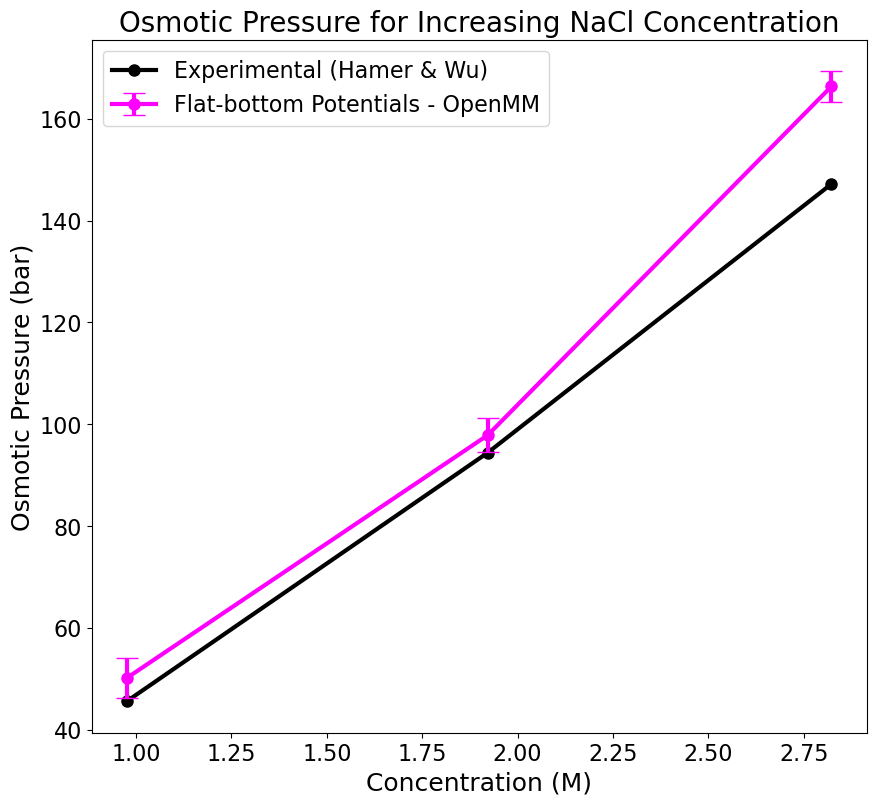

In [27]:
## Osmotic pressure plot
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,9))
plt.plot(xconc,yexpOP, marker='o', linestyle='-',color='black', label='Experimental (Hamer & Wu)',linewidth=3,markersize=8)
plt.errorbar(xconc,off_op, yerr=off_operr, fmt='o', linestyle='-',color='magenta', capsize=8, label='Flat-bottom Potentials - OpenMM',linewidth=3,markersize=8)
plt.xlabel("Concentration (M)", fontsize=MEDIUM_SIZE)
plt.ylabel("Osmotic Pressure (bar)", fontsize=MEDIUM_SIZE)
plt.title('Osmotic Pressure for Increasing NaCl Concentration', fontsize=BIGGER_SIZE)
plt.legend()
plt.savefig('filename.png')
plt.show()

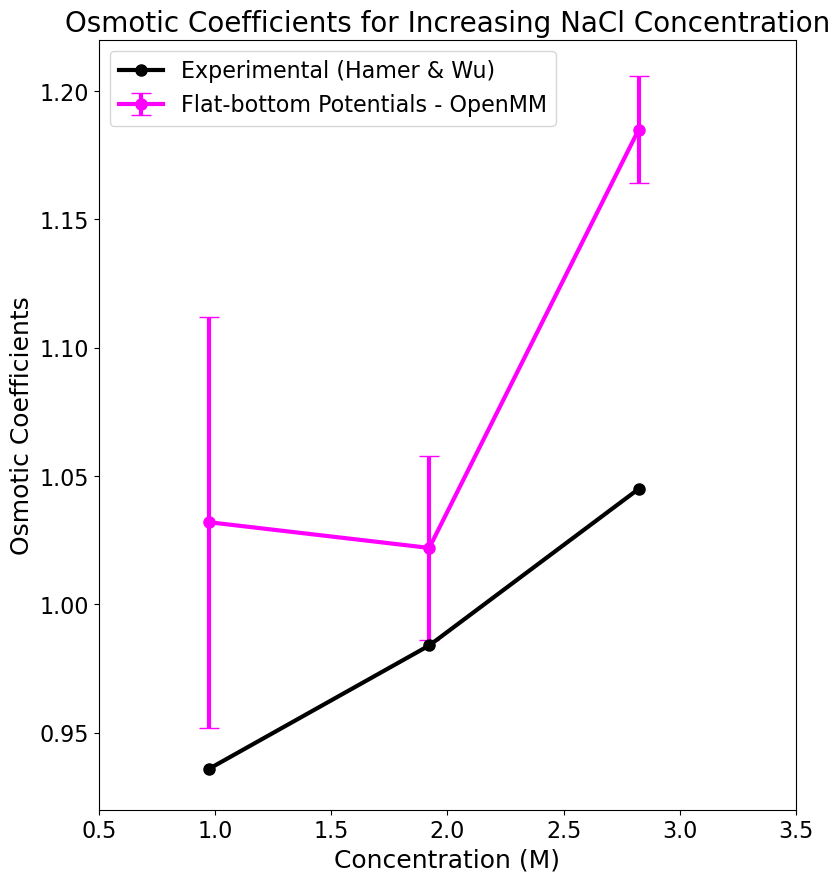

In [28]:
# Osmotic coefficient plot
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(9.0,10.0))
plt.errorbar(xconc,off_oc, yerr=off_ocerr, fmt='o', linestyle='-',color='magenta', capsize=7, label='Flat-bottom Potentials - OpenMM', lw=3, markersize=8)
plt.plot(xconc,yexpOC, marker='o', linestyle='-',color='k', label='Experimental (Hamer & Wu)', lw=3, markersize=8)
plt.xlabel("Concentration (M)",fontsize=MEDIUM_SIZE)
plt.ylabel("Osmotic Coefficients",fontsize=MEDIUM_SIZE)
plt.xlim(0.5,3.5)
plt.ylim(0.92,1.22)
plt.title('Osmotic Coefficients for Increasing NaCl Concentration', fontsize=BIGGER_SIZE)
plt.legend(prop={'size': 16}, loc='upper left')
plt.savefig('ocs.png')
plt.show()